# Моделирование одномерного уравнения переноса с циклическими граничными условиями
$$
\frac{\partial \phi}{\partial t} + u\frac{\partial \phi}{\partial x}=0
$$

In [282]:
#-ПОДКЛЮЧЕНИЕ-МОДУЛЕЙ-И-БИБЛИОТЕК-
%matplotlib notebook

import numpy              as np
import scipy
import matplotlib.pyplot  as plt
import glob
import moviepy.editor     as mpy

from scipy                import sparse
from scipy.sparse         import linalg
from numpy                import pi, sin, cos, ma
from pylab                import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib           import cm
from matplotlib.ticker    import LinearLocator, FormatStrFormatter
from matplotlib           import animation

In [283]:
#-ОПЕРАТОРЫ-ПРОСТРАНСТВЕННОГО-ДИФФЕРЕНЦИРОВАНИЯ-

def SpaceDiffLeft(f,u,h):
    A     = np.zeros(f.size)+1
    B     = np.zeros(f.size)-1
    
    data  = np.array([u/h*B, u/h*A])
    diags = np.array([-1, 0])
    D     = sparse.spdiags(data, diags, f.size, f.size).toarray()
    
    D[0,-1] =  -u/(h) #Внесение переодичности методом виртуальных точек
    
    return D@f
        
def SpaceDiffCenter2(f,u,h):
    A     = np.zeros(f.size)+1
    B     = np.zeros(f.size)-1
    
    data  = np.array([u/(2*h)*B, u/(2*h)*A])
    diags = np.array([-1, 1])
    D     = sparse.spdiags(data, diags, f.size, f.size).toarray()
    
    D[0,-1] =   -u/(2*h) #Внесение переодичности методом виртуальных точек
    D[-1,0] =    u/(2*h) #Внесение переодичности методом виртуальных точек
    
    return D@f

def SpaceDiffCenter4(f,u,h):
    A     = np.zeros(f.size)+1
    B     = np.zeros(f.size)-1
    
    data  = np.array([u/(12*h)*A, 8*u/(12*h)*B, 8*u/(12*h)*A, u/(12*h)*B])
    diags = np.array([-2, -1, 1, 2])
    D     = sparse.spdiags(data, diags, f.size, f.size).toarray()
    
    D[0,-2] =     u/(12*h) #Внесение переодичности методом виртуальных точек
    D[0,-1] =  -8*u/(12*h) #Внесение переодичности методом виртуальных точек
    D[1,-1] =     u/(12*h) #Внесение переодичности методом виртуальных точек
    
    D[-2,0] =    -u/(12*h) #Внесение переодичности методом виртуальных точек
    D[-1,0] =   8*u/(12*h) #Внесение переодичности методом виртуальных точек
    D[-1,1] =    -u/(12*h) #Внесение переодичности методом виртуальных точек
    
    return D@f

In [287]:
#-ОПЕРАТОРЫ-ВРЕМЕННОГО-ДИФФЕРЕНЦИРОВАНИЯ-
    
def TimeDiffEuler(space_scheme,f,u,h,tau):
    
    if (space_scheme == 'left'):
        for j in range(f[:,0].size-1):
            f[j+1,:] = f[j,:] - tau*SpaceDiffLeft(f[j,:],u,h)
            
def TimeDiffRK4(space_scheme,f,u,h,tau):
    
    if(space_scheme == 'left'):
        def F(f,u,h,tau):
            return -SpaceDiffLeft(f,u,h)
        
    elif(space_scheme == 'center2'):
        def F(f,u,h,tau):
            return -SpaceDiffCenter2(f,u,h)
    
    elif(space_scheme == 'center4'):
        def F(f,u,h,tau):
            return -SpaceDiffCenter4(f,u,h)
        
    def w1(f,u,h,tau):
        return F(f,u,h,tau)
    def w2(f,u,h,tau):
        return F(f+tau/2*w1(f,u,h,tau),u,h,tau)
    def w3(f,u,h,tau):
        return F(f+tau/2*w2(f,u,h,tau),u,h,tau)
    def w4(f,u,h,tau):
        return F(f+tau*w3(f,u,h,tau),u,h,tau)
    for j in range(f[:,0].size-1):
        f[j+1,:] = f[j,:] + tau/6*(w1(f[j,:],u,h,tau)+2*w2(f[j,:],u,h,tau)+2*w3(f[j,:],u,h,tau)+w4(f[j,:],u,h,tau))

In [288]:
#-ФУНКЦИЯ-СЧЕТА-ОДНОМЕРНОГО-УРАВНЕНИЯ-ПЕРЕНОСА-С-ВИРТУАЛЬНЫМИ-ТОЧКАМИ-
#------входные-аргументы------
# * sheme_name - схема для счета ('RK4+left', 'RK4+center2', 'RK4+center4', 'euler+left')
# * x_max - отрезок пространства, на котором строится схема
# * t_max - отрезок времени, на котором строится схема
# * x_count - число отрезков разбиения
# * t_count - число слоев по времени
# * u - постоянная скорость (параметр задачи)
# * SC = start condition

def CyclicScheme1TransportEquation(scheme_name, x_max, t_max, count_x, count_t, u, SC):
    
    
    #--------------------EULER+LEFT--------------------
    if (scheme_name == 'euler+left'):
        
        #расчет параметров
        h   = (x_max)/count_x
        tau = (t_max)/count_t
        i_s =  1
        i_e = -1
        #расчет сеток
        x   = np.arange(i_e, (count_x+1) + i_s, dtype=double)*h
        t   = np.arange( 0, (count_t+1)    , dtype=double)*tau
        PHI = np.zeros((t.size,x.size))
        
        print("Число Куранта: ")
        print(u*tau/h)
        
        #начальные условия
        PHI[0,i_s:i_e] = SC
        PHI[0,0]       = SC[i_e-1]
        PHI[0,-1]      = SC[i_s]
        
        #вычисление
        TimeDiffEuler('left',PHI,u,h,tau)
        
        return [x[i_s:i_e], t, PHI[:,i_s:i_e]]
    
    
    #--------------------RK4+LEFT--------------------
    elif (scheme_name == 'RK4+left'):
        
        #параметры задачи
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        i_s =  1
        i_e = -1
        
        print("Число Куранта: ")
        print(u*tau/h)
        
        #расчет сеток
        x   = np.arange(i_e, (count_x+1) + i_s, dtype=double)*h
        t   = np.arange( 0, (count_t+1)    , dtype=double)*tau
        PHI = np.zeros((t.size,x.size))
        
        #начальные условия
        PHI[0,i_s:i_e] = SC
        PHI[0,0]       = SC[i_e-1]
        PHI[0,-1]      = SC[i_s]
        
        #вычисление
        TimeDiffRK4('left',PHI,u,h,tau)
        
        return [x[i_s:i_e], t, PHI[:,i_s:i_e]]
    
    
    #--------------------RK4+CENTER2--------------------
    elif (scheme_name == 'RK4+center2'):
        
        #параметры задачи
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        i_s =  1
        i_e = -1
        
        print("Число Куранта: ")
        print(u*tau/h)
        
        #расчет сеток
        x   = np.arange(i_e, (count_x+1) + i_s, dtype=double)*h
        t   = np.arange( 0, (count_t+1)    , dtype=double)*tau
        PHI = np.zeros((t.size,x.size))
        
        #начальные условия
        PHI[0,i_s:i_e] = SC
        PHI[0,0]       = SC[i_e-1]
        PHI[0,-1]      = SC[i_s]
        
        #вычисление
        TimeDiffRK4('center2',PHI,u,h,tau)
        
        return [x[i_s:i_e], t, PHI[:,i_s:i_e]]
    
    #--------------------RK4+CENTER4--------------------
    elif (scheme_name == 'RK4+center4'):
        
        #параметры задачи
        h      = (x_max)/count_x
        tau    = (t_max)/count_t
        i_s =  2
        i_e = -2
        
        print("Число Куранта: ")
        print(u*tau/h)
        
        #расчет сеток
        x   = np.arange(i_e, (count_x+1) + i_s, dtype=double)*h
        t   = np.arange( 0, (count_t+1)    , dtype=double)*tau
        PHI = np.zeros((t.size,x.size))
        
        #начальные условия
        PHI[0,i_s:i_e] = SC
        PHI[0,0]       = SC[i_e-2]
        PHI[0,1]       = SC[i_e-1]
        PHI[0,-1]      = SC[i_s+1]
        PHI[0,-2]      = SC[i_s]
        
        #вычисление
        TimeDiffRK4('center4',PHI,u,h,tau)
        
        return [x[i_s:i_e], t, PHI[:,i_s:i_e]]
    
    

Число Куранта: 
1.0


<IPython.core.display.Javascript object>


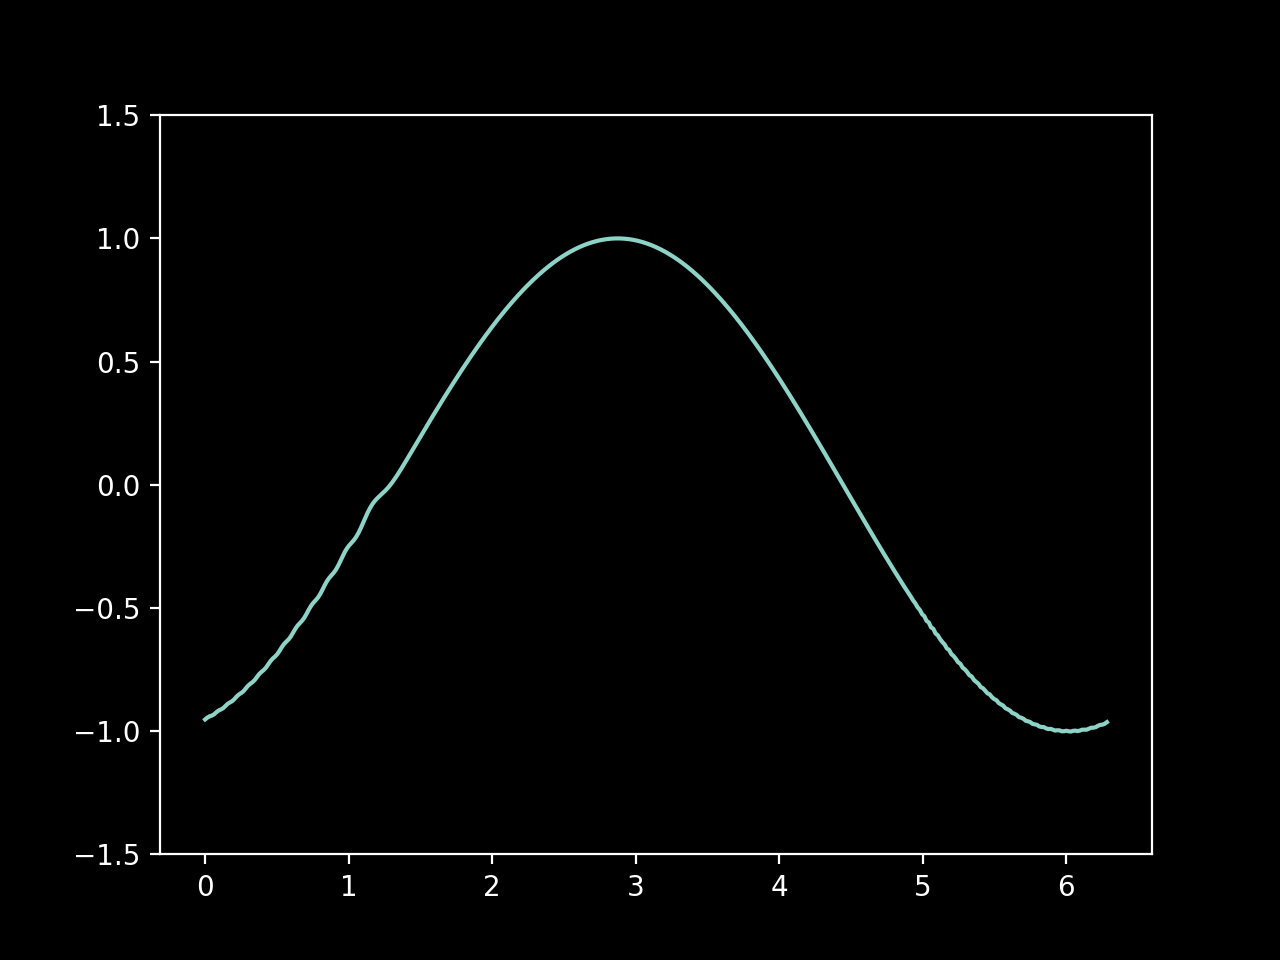

In [289]:
x_max   = 2*pi
t_max   = 2*pi
count_t = 400
count_x = 400

[x,t,PHI] = CyclicScheme1TransportEquation('RK4+center2', x_max, t_max, count_x, count_t, 1, sin(np.arange(0, (count_x+1), dtype=double)*x_max/count_x))

#-ВИЗУАЛИЗАЦИЯ-
fig, ax = plt.subplots()
plt.style.use('dark_background')
surf = ax.plot(x,PHI[0])

def animate(n):
    plt.style.use('dark_background')
    ax.clear()
    ax.set_ylim(-1.5,1.5)
    surf = ax.plot(x,PHI[n])
    return surf

anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=1, repeat = False)